<a href="https://colab.research.google.com/github/kaaanishk/face-detection-optimised/blob/master/Face_Detection_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Run only **"Face Detection Final"** for a demo of the implementation. All other sections are only for testing and development purposes.

# Setting Up

In [2]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/85/81/65/6363fa5aafd7a155c896591e0c7c6e27b69642aa82b9cbf076
Successfully built mtcnn


In [0]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from scipy import ndimage
from mtcnn.mtcnn import MTCNN

import urllib
from google.colab.patches import cv2_imshow

mtcnn = MTCNN()

# Helper Functions

In [0]:
def resize_image(image, width=600):
  """
  This function is used to resize images given the width in pixels.
  The height of the resized image is calculated based on the given width.
  By default, the width of the output image is set to 600px since
  our model seems to perform best with images of this size.
  
  """
  r = width / image.shape[1]
  dim = (width, int(image.shape[0] * r))
  resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  return resized_image

In [0]:
def plot_histogram(image):
  """
  This function is used to plot the histogram for any given image.
  
  """
  hist, bins = np.histogram(image.flatten(),256,[0,256])
  cdf = hist.cumsum()
  cdf_normalized = cdf * hist.max()/ cdf.max()

  plt.plot(cdf_normalized, color = 'b')
  plt.hist(image.flatten(),256,[0,256], color = 'r')
  plt.xlim([0,256])
  plt.legend(('cdf','histogram'), loc = 'upper left')
  plt.show()

In [0]:
def read_from_url(url):
  url_response = urllib.request.urlopen(url)
  image_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
  image = cv2.imdecode(image_array, -1)
  
  return image

In [0]:
def adjust_gamma(image, gamma=1.0):
  """
  This function is used to make a Lookup Table (LUT)
  to adjust the gamma value for each pixel accordingly
  
	"""
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# Return image which is gamma corrected using the LUT
  return cv2.LUT(image, table)

In [0]:
def apply_clahe(image):
  
  """
  This function is used to convert the input `image` with RGB profile,
  into LAB color profile.
  We do this since Contrast Limited Adaptive Histogram Equalisation(CLAHE)
  is done on grayscale images only, and the 'L' component of the LAB
  color profile helps us isolate the greyscale data while preserving color
  
  """
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  lab_planes = cv2.split(lab)
  clahe = cv2.createCLAHE()
  lab_planes[0] = clahe.apply(lab_planes[0])
  lab = cv2.merge(lab_planes)
  img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  
  return img_clahe

In [0]:
def generate_faces(result_mtcnn, input_image):
  for i in range(0,len(result_mtcnn)):
    bounding_box = result_mtcnn[i]['box']
    keypoints = result_mtcnn[i]['keypoints']

    cv2.rectangle(input_image,
                  (bounding_box[0],  bounding_box[1]),
                  (bounding_box[0] + bounding_box[2],
                   bounding_box[1] + bounding_box[3]),
                  (0,155,255), 2)
    cv2.circle(input_image,(keypoints['left_eye']), 2, (0,155,255), 2)
    cv2.circle(input_image,(keypoints['right_eye']), 2, (0,155,255), 2)
    cv2.circle(input_image,(keypoints['nose']), 2, (0,155,255), 2)
    cv2.circle(input_image,(keypoints['mouth_left']), 2, (0,155,255), 2)
    cv2.circle(input_image,(keypoints['mouth_right']), 2, (0,155,255), 2)
  

In [0]:
def tan_triggs(X, alpha=0.1,gamma=0.2, sigma0=1, sigma1=2, tau=10):
  X = np.array(X, dtype = np.float32)
  X = np.power(X, gamma)
  
  s0 = 3 * sigma0
  s1 = 3 * sigma1
  
  if (s0 % 2) == 0:
    s0 += 1
  if (s1 % 2) == 0:
    s1 += 1
    
  # Taking Difference of Gaussian Filters
  X = np.asarray( ndimage.gaussian_filter( X, sigma0 ) - ndimage.gaussian_filter( X, sigma1))
  
  X = X / np.power( np.mean( np.power( np.abs(X), alpha ) ), 1.0/alpha )
  
  X = X / np.power( np.mean( np.power( np.minimum( np.abs(X), tau ), alpha ) ), 1.0/alpha )
  
  X = np.tanh( X / tau ) * tau
  
  X = cv2.normalize(X, X, -220, 0, cv2.NORM_MINMAX)
  
  return np.array(X, np.uint8)

# Testing Histogram Equalisation Techniques

In [0]:
img = read_from_url("")
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img_yuv2 = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

**Input Image Analysis**

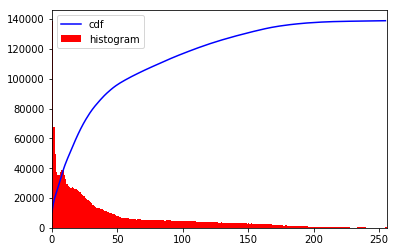

In [0]:
#basic
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()


#plot
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.savefig('basic_hist.png', bbox_inches = 'tight')
plt.show()

**Basic Histogram Equalization**

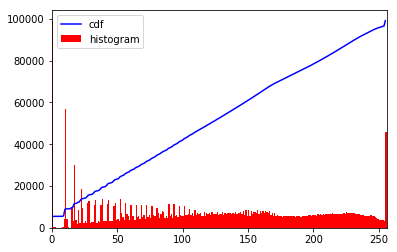

In [0]:
#basic histogram equalisation
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
img_eq_hist = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)


#plot
hist, bins = np.histogram(img_eq_hist.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img_eq_hist.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.savefig('basic_eq_hist.png', bbox_inches = 'tight')
plt.show()


**CLAHE (Adaptive Histogram Equalisation)**

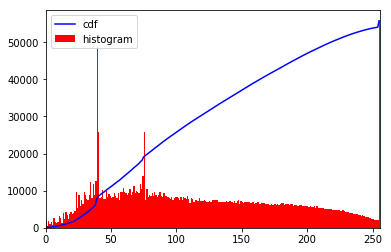

In [0]:
#clahe
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
lab_planes = cv2.split(lab)
clahe = cv2.createCLAHE()
lab_planes[0] = clahe.apply(lab_planes[0])
lab = cv2.merge(lab_planes)
img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


#plot
hist, bins = np.histogram(img_clahe.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img_clahe.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.savefig('clahe.png', bbox_inches = 'tight')
plt.show()

**Comparison of Outputs**

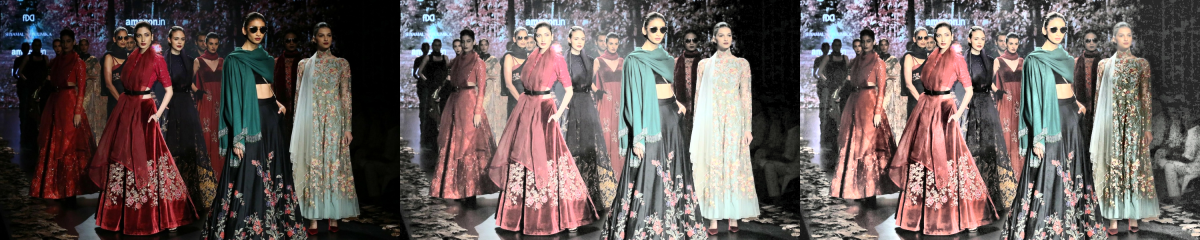

In [0]:
#compiled difference
res = np.hstack((img, img_eq_hist, img_clahe))
r = 1200.0 / res.shape[1]
dim = (1200, int(res.shape[0] * r))
resized = cv2.resize(res, dim, interpolation = cv2.INTER_AREA)
cv2_imshow(resized)

# Gamma Correction Tuning and Testing

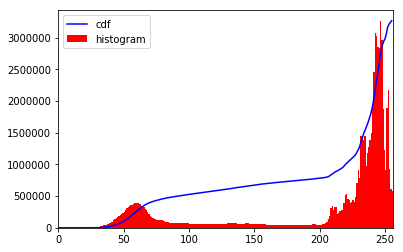

In [259]:
#Read image from link !!TODO!! add functionality to read from the excel file
img = read_from_url("https://shieldasset.timesgroup.com/toi/MultiplePath/ResizeImage/84B4E5BA-1BBC-45E8-AA49-890400589F08-rot-06492019074910dpi06061907491106062019071149.jpg")

#img=cv2.imread("test_4.jpg")
plot_histogram(img)

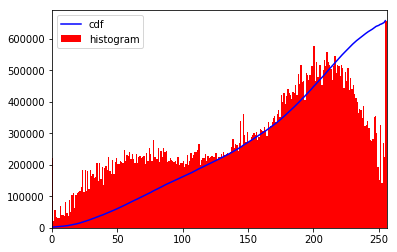

In [260]:
#Apply Gamma Correction followed by CLAHE 
img_gclahe = adjust_gamma(img,1.6)
img_gclahe = apply_clahe(img_gclahe)
plot_histogram(img_gclahe)

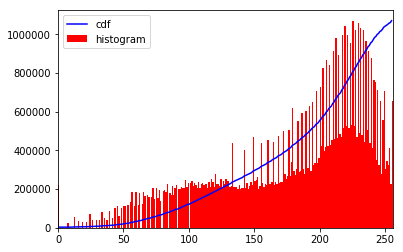

In [261]:
#Apply CLAHE followed by Gamma Correction
img_clahe = apply_clahe(img)
img_cgamma = adjust_gamma(img_clahe, 1.6)
plot_histogram(img_cgamma)

In [262]:
img_r_cgamma = resize_image(img_cgamma,600)
img_r_gclahe = resize_image(img_gclahe, 600)

result_cgamma = mtcnn.detect_faces(img_r_cgamma)
result_gclahe = mtcnn.detect_faces(img_r_gclahe)

print("For CLAHE + Gamma Correction: ", len(result_cgamma),
      "\nFor Gamma Correction + CLAHE: ", len(result_gclahe))

For CLAHE + Gamma Correction:  3 
For Gamma Correction + CLAHE:  2


In [0]:
result_image_cgamma = img_r_cgamma
result_image_gclahe = img_r_gclahe

generate_faces(result_cgamma, result_image_cgamma)
generate_faces(result_gclahe, result_image_gclahe)



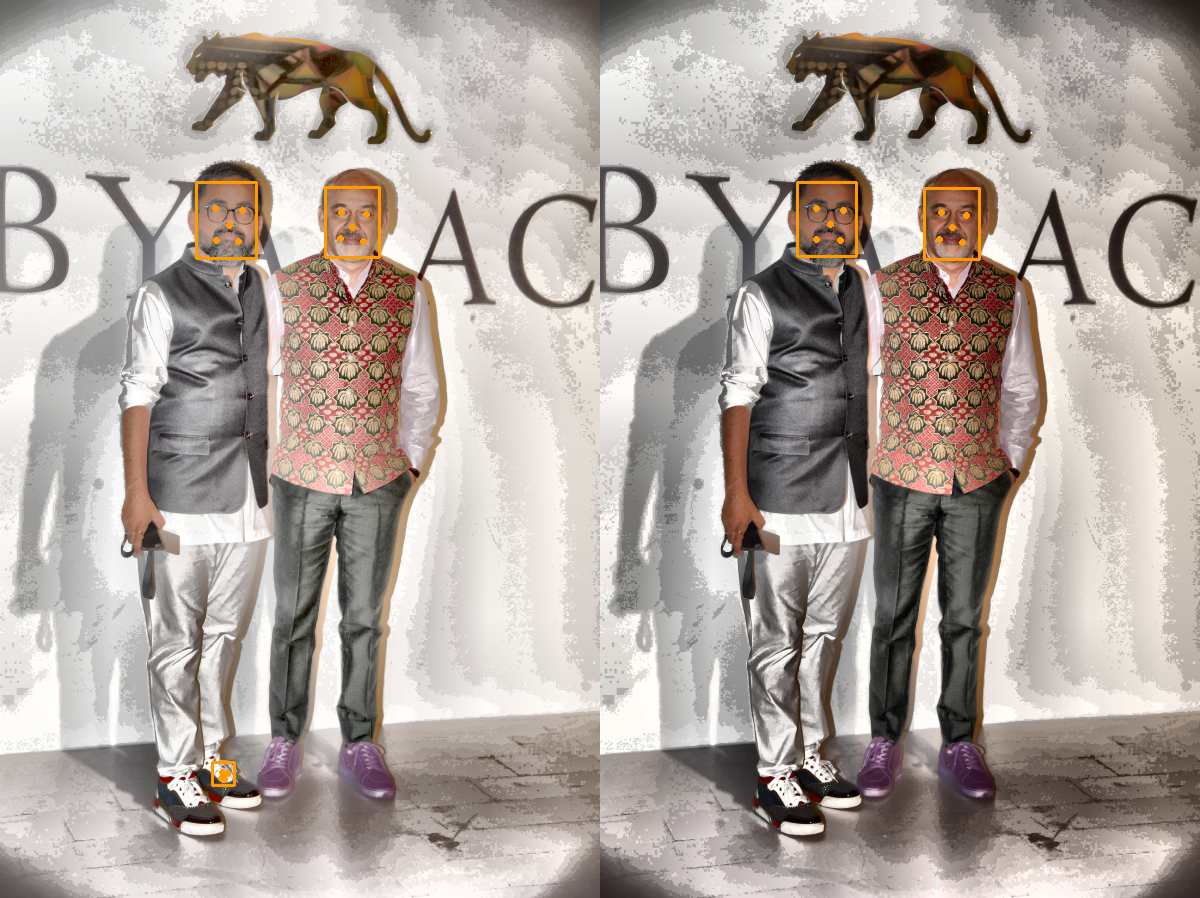

In [264]:
comparison = np.hstack((result_image_cgamma, result_image_gclahe))
cv2_imshow(comparison)

In [60]:
"""
Since the results in CLAHE + Gamma Correction handle the unwanted
detection as shown in the test, while maintaining accuracy, Gamma Correction
is added to the image preprocessing pipeline.

"""

'\nSince the results in CLAHE + Gamma Correction handle the unwanted\ndetection as shown in the test, while maintaining accuracy, Gamma Correction\nis added to the image preprocessing pipeline.\n\n'

# Testing TanTriggs Algorithm

In [0]:
img = read_from_url("https://shieldasset.timesgroup.com/toi/MultiplePath/ResizeImage/F950E530-38F7-4A81-BAE0-6EFC0027718Ddpi09061909091409062019091409.jpg")

In [0]:
img_p = adjust_gamma(img, 1.6)
img_p= apply_clahe(img_p)


lab = cv2.cvtColor(img_p, cv2.COLOR_BGR2LAB)
lab_planes = cv2.split(lab)

lab_planes[0] = tan_triggs(lab_planes[0])

lab = cv2.merge(lab_planes)
img_p = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


img_p = resize_image(img_p, 600)

In [75]:
result = mtcnn.detect_faces(img_p)
print(result)

[]


In [76]:
result2 = mtcnn.detect_faces(img)
print(result2)

[]


In [0]:
generate_faces(result, img_tt)
generate_faces(result2, img)

In [0]:
cv2_imshow(img)

# **Testing Face Detection with Basic Histogram Equalisation and CLAHE Methods**

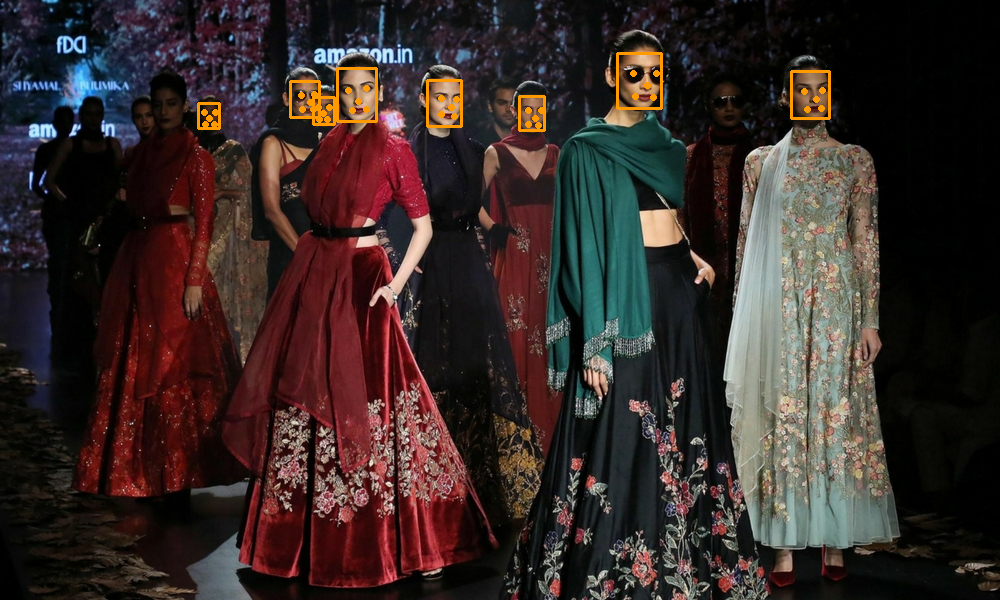

In [0]:
#basic face detection
result = mtcnn.detect_faces(img)

for i in range(0,len(result)):
  bounding_box = result[i]['box']
  keypoints = result[i]['keypoints']

  cv2.rectangle(img,
                (bounding_box[0],  bounding_box[1]),
                (bounding_box[0] + bounding_box[2],
                 bounding_box[1] + bounding_box[3]),
                (0,155,255), 2)
  cv2.circle(img,(keypoints['left_eye']), 2, (0,155,255), 2)
  cv2.circle(img,(keypoints['right_eye']), 2, (0,155,255), 2)
  cv2.circle(img,(keypoints['nose']), 2, (0,155,255), 2)
  cv2.circle(img,(keypoints['mouth_left']), 2, (0,155,255), 2)
  cv2.circle(img,(keypoints['mouth_right']), 2, (0,155,255), 2)

  
cv2.imwrite("1_drawn.jpg", img)
cv2_imshow(img)

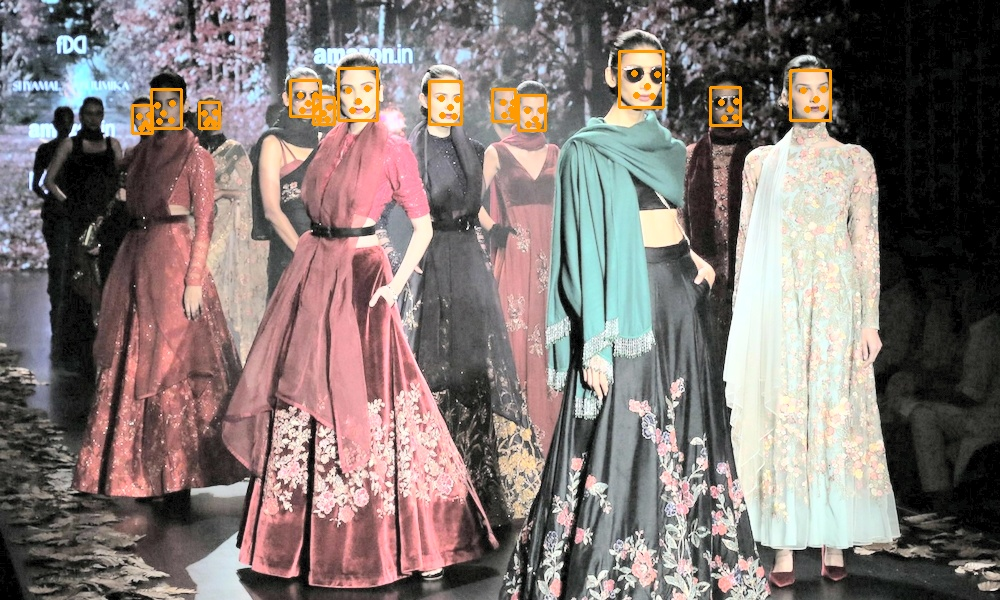

In [0]:
#histogram equalisation
result_eq_hist = mtcnn.detect_faces(img_eq_hist)


for i in range(0,len(result_eq_hist)):
  bounding_box = result_eq_hist[i]['box']
  keypoints = result_eq_hist[i]['keypoints']

  cv2.rectangle(img_eq_hist,
                (bounding_box[0],  bounding_box[1]),
                (bounding_box[0] + bounding_box[2],
                 bounding_box[1] + bounding_box[3]),
                (0,155,255), 2)
  cv2.circle(img_eq_hist,(keypoints['left_eye']), 2, (0,155,255), 2)
  cv2.circle(img_eq_hist,(keypoints['right_eye']), 2, (0,155,255), 2)
  cv2.circle(img_eq_hist,(keypoints['nose']), 2, (0,155,255), 2)
  cv2.circle(img_eq_hist,(keypoints['mouth_left']), 2, (0,155,255), 2)
  cv2.circle(img_eq_hist,(keypoints['mouth_right']), 2, (0,155,255), 2)
  
cv2.imwrite("2_drawn.jpg", img_eq_hist)
cv2_imshow(cv2.imread("2_drawn.jpg"))

In [0]:
#clahe
result_clahe = mtcnn.detect_faces(img_clahe)


for i in range(0,len(result_clahe)):
  bounding_box = result_clahe[i]['box']
  keypoints = result_clahe[i]['keypoints']

  cv2.rectangle(img_clahe,
                (bounding_box[0],  bounding_box[1]),
                (bounding_box[0] + bounding_box[2],
                 bounding_box[1] + bounding_box[3]),
                (0,155,255), 2)
  cv2.circle(img_clahe,(keypoints['left_eye']), 2, (0,155,255), 2)
  cv2.circle(img_clahe,(keypoints['right_eye']), 2, (0,155,255), 2)
  cv2.circle(img_clahe,(keypoints['nose']), 2, (0,155,255), 2)
  cv2.circle(img_clahe,(keypoints['mouth_left']), 2, (0,155,255), 2)
  cv2.circle(img_clahe,(keypoints['mouth_right']), 2, (0,155,255), 2)
  
cv2.imwrite("3_drawn.jpg", img_clahe)
cv2_imshow(cv2.imread("3_drawn.jpg"))

# **Face Detection Final**

Based on the results above, we go ahead with a combination of Gamma Correction and CLAHE as the algorithms of choice since they give the best results for the experimental data.

### Progress
- [x] ~~Pre-processing~~
- [x] ~~Detection~~
- [ ] Convert Bounding Boxes to Square
- [ ] Crop Faces

## Importing Libraries

All the libraries we will be using will be imported and installed in this section.
Run the  `pip install` commands before importing the packages to avoid any errors.

> **Note:** Ignore depracation warnings; use of certain libraries in the core packages cause these to occur. There shouldn't be any issues with the reamining program because of this.

In [77]:
!pip install mtcnn

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from scipy import ndimage
from mtcnn.mtcnn import MTCNN

import urllib
from google.colab.patches import cv2_imshow

## Helper Functions

This section contains various helper functions which are used multiple times throughout the implementation.
Description for each function is attached with the code.

In [0]:
def read_from_url(url):
  """
  This function is used to read an image from a given URL.
  
  Input:
  
  """
  url_response = urllib.request.urlopen(url)
  image_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
  image = cv2.imdecode(image_array, -1)
  
  return image


In [0]:
def plot_histogram(image):
  """
  This function is used to plot the histogram for any given image.
  
  """
  hist, bins = np.histogram(image.flatten(),256,[0,256])
  cdf = hist.cumsum()
  cdf_normalized = cdf * hist.max()/ cdf.max()

  plt.plot(cdf_normalized, color = 'b')
  plt.hist(image.flatten(),256,[0,256], color = 'r')
  plt.xlim([0,256])
  plt.legend(('cdf','histogram'), loc = 'upper left')
  plt.show()
  

In [0]:
def adjust_gamma(image, gamma=1.0):
  """
  This function is used to make a Lookup Table (LUT)
  to adjust the gamma value for each pixel accordingly
  
	"""
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# Return image which is gamma corrected using the LUT
  return cv2.LUT(image, table)

In [0]:
def apply_clahe(image):
  
  """
  This function is used to convert the input `image` with RGB profile,
  into LAB color profile.
  We do this since Contrast Limited Adaptive Histogram Equalisation(CLAHE)
  is done on grayscale images only, and the 'L' component of the LAB
  color profile helps us isolate the greyscale data while preserving color
  
  """
  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  lab_planes = cv2.split(lab)
  clahe = cv2.createCLAHE()
  lab_planes[0] = clahe.apply(lab_planes[0])
  lab = cv2.merge(lab_planes)
  img_clahe = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  
  return img_clahe


In [0]:
def resize_image(image, width=600):
  """
  This function is used to resize images given the width in pixels.
  The height of the resized image is calculated based on the given width.
  By default, the width of the output image is set to 600px since
  our model seems to perform best with images of this size.
  
  """
  r = width / image.shape[1]
  dim = (width, int(image.shape[0] * r))
  resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  return resized_image


In [0]:
def tan_triggs(X, alpha=0.1,gamma=0.2, sigma0=1, sigma1=2, tau=10):
  X = np.array(X, dtype = np.float32)
  X = np.power(X, gamma)
  
  s0 = 3 * sigma0
  s1 = 3 * sigma1
  
  if (s0 % 2) == 0:
    s0 += 1
  if (s1 % 2) == 0:
    s1 += 1
    
  # Taking Difference of Gaussian Filters
  X = np.asarray( ndimage.gaussian_filter( X, sigma0 ) - ndimage.gaussian_filter( X, sigma1))
  X = X / np.power( np.mean( np.power( np.abs(X), alpha ) ), 1.0/alpha ) 
  X = X / np.power( np.mean( np.power( np.minimum( np.abs(X), tau ), alpha ) ), 1.0/alpha )
  X = np.tanh( X / tau ) * tau
  X = cv2.normalize(X, X, -220, 0, cv2.NORM_MINMAX)
  
  return np.array(X, np.uint8)


In [0]:
def generate_faces(result_mtcnn, input_image):
  for i in range(0,len(result_mtcnn)):
    bounding_box = result_mtcnn[i]['box']
    keypoints = result_mtcnn[i]['keypoints']

    cv2.rectangle(input_image,
                  (bounding_box[0],  bounding_box[1]),
                  (bounding_box[0] + bounding_box[2],
                   bounding_box[1] + bounding_box[3]),
                  (0,155,255), 2)
    cv2.circle(input_image,(keypoints['left_eye']), 2, (0,155,255), 2)
    cv2.circle(input_image,(keypoints['right_eye']), 2, (0,155,255), 2)
    cv2.circle(input_image,(keypoints['nose']), 2, (0,155,255), 2)
    cv2.circle(input_image,(keypoints['mouth_left']), 2, (0,155,255), 2)
    cv2.circle(input_image,(keypoints['mouth_right']), 2, (0,155,255), 2)
  

## Declarations

This section contains all variable declatations and initialisations.

In [0]:
mtcnn = MTCNN()

url = "https://shieldasset.timesgroup.com/toi/MultiplePath/ResizeImage/99C1A2C2-B391-4E3A-9154-1BB62B489AAAdpi09061908533109062019083153.jpg"
img = read_from_url(url)

## Pre-processing Pipeline

The entire pipeline begins with pre-processing the input image before going ahead with detection.

### Steps for pre-processing:
1. Gamma Correction
2. Contrast Limited Adaptive Histogram Equalisation (CLAHE)
3. Resize Image

In [0]:
#Gamma Correction
img = adjust_gamma(img, 1.6)

In [0]:
#CLAHE
img = apply_clahe(img)

In [0]:
#Resize Image
img = resize_image(img, 600)

## Detection

In [0]:
#Detect Faces in the processed image
result = mtcnn.detect_faces(img)

In [0]:
#Draw Faces on a copy of the image
img_p = img
generate_faces(result,img_p)

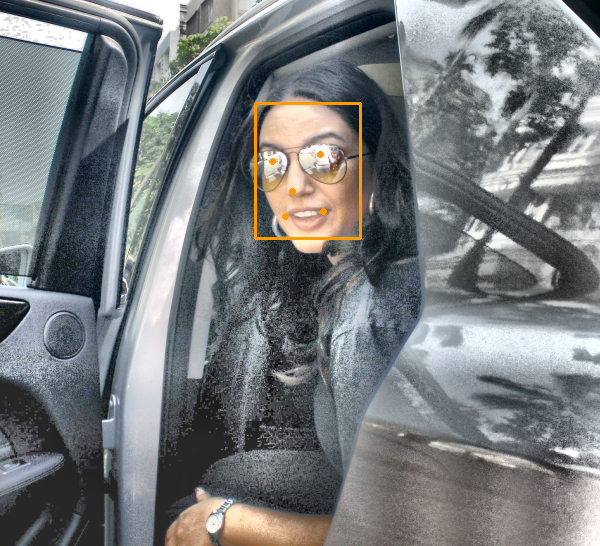

In [92]:
cv2_imshow(img_p)